# Part I:

## Prove $L(Y;X)$ is monotone in $MLE(Y,\hat{Y}|X)$
L is the likelyhood of a linear regression model. as such, we can write:
$$ L(Y;X) = \Sigma_i \frac{e^{- \frac{(y_i-f(x_i,\theta))^2}{2\sigma^2}}}{\sqrt{2\pi\sigma^2}}$$
where we try to maximize the likelyhood w.r.t theta:
because $log(x)$ is monotone in x, this can be written as:

$$ \underset{\theta}{\text{max}} \Sigma_i \log{\frac{e^{\frac{(y_i-f(x_i,\theta))^2}{2\sigma^2}}}{\sqrt{2\pi\sigma^2}}} =  \Sigma_i - \frac{(y_i-f(x_i,\theta))^2}{2\sigma^2} - (\sqrt{2\pi\sigma^2}) $$

substituting $f(x_i,\theta)$ with $\hat{y}$, eliminating all parts that are constants w.r.t $\theta$ we get:

$$ \underset{\theta}{\text{max}}   \Sigma_i  -(y_i-f(x_i,\theta))^2$$

cahnging the maximization of a negative function to the minimization of a positive function, summing for all $(x_i,y_i)$ and dividing by the number of samples n we get exactly the MSE which is monotone in the likelyhood:

$$ \underset{\theta}{\text{min}}   \frac{1}{n}(Y-\hat{Y})^2$$

## find the derivative of the sigmoid function
$$f(x) = \frac{1}{1+e^{-x}}$$

$$f'(x) = \frac{-1}{(1+e^{-x})^2} \frac{d}{dx}(1+e^{-x})=\frac{(-1)(-e^{-x})}{(1+e^{-x})^2}$$

$$f'(x) = \frac{e^{-x}}{(1+e^{-x})^2}$$


## Why argmax(x)  is not suitable for NN?

because it is not deifferentiable and therfore the NN would not be able to backpropagate it's errors. a softmax function will be the best substitude for this function as it will give a high value to the highest x of X, but will still keep values on the other classes

## Prove that scaled softmax function when c->infinity is equal to argmax(X)

$$S(x_i,c)=\frac{e^{x_i(c)}}{\sum_{k=1}^{n}e^{x_k(c)}}$$

$$S(x_i,c)_{c\rightarrow\infty}=\frac{e^{x_i(c)}}{\sum_{k=1}^{n}e^{x_k(c)}}$$

lets say that $x_j$ is the max value of X,
for $i \neq j$ we get:

$$S(x_i,c)_{c\rightarrow\infty}=\frac{e^{x_i(c)}}{e^{x_j(c)} + L.O.T} =e^{(x_i-x_j)(c)} \rightarrow 0 $$

and for $i \neq j$ we get:

$$S(x_j,c)_{c\rightarrow\infty}=\frac{e^{x_j(c)}}{e^{x_j(c)} + L.O.T} =e^{(x_j-x_j)(c)} \rightarrow 1 $$

which is the exact definition of argmax(x)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Part 2 - Build a MLP

### One perceptron for classification of round(x)

I tryied to create a perceptron neuron to understand NN mechanics

/home/sagiv/anaconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


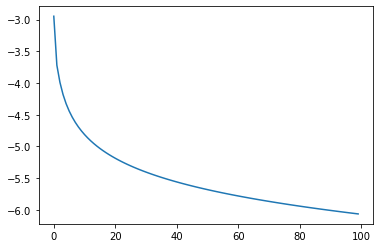

In [2]:
from NN import Perceptron

s = 1000
x= np.random.random(s+1)
y = np.round(x)
p1 = Perceptron(np.random.random(),np.random.random(),0.1, 'sigmoid')
e = p1.train(x,y,100)
plt.plot(np.log(e))

## Fully connected network

In [3]:
import pdb

In [4]:
class Layer():

    def __init__(self, n_inputs, n_outputs, activation_function, learning_rate):
        self.activation_function = self.__getattribute__(activation_function)
        self.activation_function_ = self.__getattribute__(activation_function + '_')
        self.learning_rate = learning_rate
        self.n_in = n_inputs
        self.n_out = n_outputs
        self.w = np.random.uniform(0, 1, (self.n_in, self.n_out)) / np.sqrt(self.n_out)
        self.b = np.random.uniform(0, 1, (1, self.n_out))

    def forward(self, x):
        # raw input to layer
        self.x = x
        # linear output of the layer
        self.lx = np.add(np.matmul(self.x, self.w), self.b)
        # return after activation function
        return self.activation_function(self.lx)

    def backward(self, dz):
        # df=dsigma(wx+b)/dL * dL/dy_p
        df = np.multiply(self.activation_function_(self.lx).reshape(dz.shape), dz).reshape(self.lx.shape)
        dw = np.matmul(self.x.T, df)
        db = np.sum(df, axis=0).reshape(-1, 1)
        dx = np.matmul(df, self.w.T)
        self.w -= self.learning_rate * dw
        self.b -= self.learning_rate * db.T
        return dx

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_(self, y):
        return np.exp(-y) / (1 + np.exp(-y)) ** 2

    def tanh(self, x):
        return 2 / (1 + np.exp(-2 * x)) - 1

    def tanh_(self, y):
        return 1 - (self.tanh(y)) ** 2

    def relu(self, x):
        mx = np.copy(x)
        mx[x <= 0] = 0
        return mx

    def relu_(self, y):
        my = np.copy(y)
        my[y <= 0] = 0
        my[y > 0] = 1
        return my

    def identity(self, y):
        return y

    def identity_(self, y):
        return np.ones_like(y)


class Network():

    def __init__(self, loss_function='mse', learning_rate=1e-5):
        self.loss_function = self.__getattribute__(loss_function)
        self.loss_function_ = self.__getattribute__(loss_function + '_')
        self.learning_rate = learning_rate
        self.layers = []

    def add_layer(self, n_inputs, n_outputs, activation_function):
        self.layers.append(Layer(n_inputs, n_outputs, activation_function, self.learning_rate))

    def forward(self, x):
        my = np.copy(x)
        for layer in self.layers:
            my = layer.forward(my)
        return my

    def backward(self, dy):
        dx = np.copy(dy)
        for layer in self.layers[::-1]:
            dx = layer.backward(dx)
        return dx

    def fit(self, x, y, batch_size=10, epochs=10):
        e = np.zeros(epochs)
        for j in range(epochs):
            idx = np.random.choice(range(len(y)), size=batch_size, replace=True)
            if len(x.shape) > 1:
                xb = x[idx, :]
            else:
                xb = x[idx]
            yb = y[idx]
            y_p = self.forward(xb)
            e[j] = self.loss_function(y_p, yb)
            de_dy = self.loss_function_(y_p, yb)
            self.backward(de_dy)
        return e

    def predict(self, X):
        return self.forward(X)

    def mse_(self, y_predicted, y_actual):
        y_predicted = y_predicted.reshape(y_actual.shape)
        return (y_predicted - y_actual) / len(y_actual)

    def mse(self, y_predicted, y_actual):
        y_predicted = y_predicted.reshape(y_actual.shape)
        return np.sqrt(sum(.5 * (y_predicted - y_actual) ** 2)) / len(y_actual)

    def cross_entropy(self, y_p, y):
        y_p = y_p.reshape(y.shape)
        y_p[y_p<=0] = 1e-5
        return sum(-np.multiply(y, np.log(y_p)) - np.multiply((1 - y), np.log(1 - y_p)))

    def cross_entropy_(self, y_p, y):
        y_p = y_p.reshape(y.shape)
        y_p[y_p<=0] = 1e-5
        return (-np.divide(y, y_p) + np.divide(1 - y, 1 - y_p))/ len(y)

## Show training results on the two datasets

### dataset 1 (one_hidden_data)

In [5]:
df = pd.read_csv('one_hidden_data.csv', header=None)
X = np.array(df.iloc[:, 0:2])
y = np.array(df.iloc[:, 2]).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
df.sample(5)

,0,1,2
657,116.0,166.0,0.142910
399,160.0,55.0,-0.068731
148,143.0,38.0,-0.068721
174,85.0,1.0,-1.456427
594,17.0,54.0,-1.087514


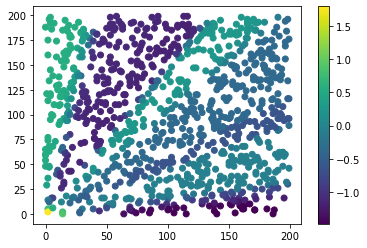

In [7]:
plt.scatter(df.iloc[:,0],df.iloc[:,1],c = df.iloc[:,2])
plt.colorbar()

In [8]:
network = Network('mse',.01)
network.add_layer(2,50,'sigmoid')
network.add_layer(50,1,'identity')

batch_size = 30
epochs = 10000
e = network.fit(X_train, y_train,batch_size,epochs)
y_pred = network.predict(X_train)

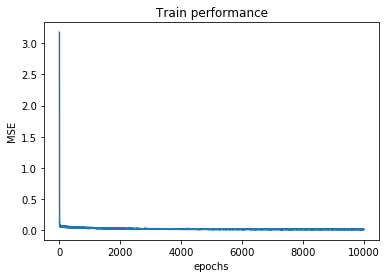

In [9]:
plt.plot(e)
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Train performance');

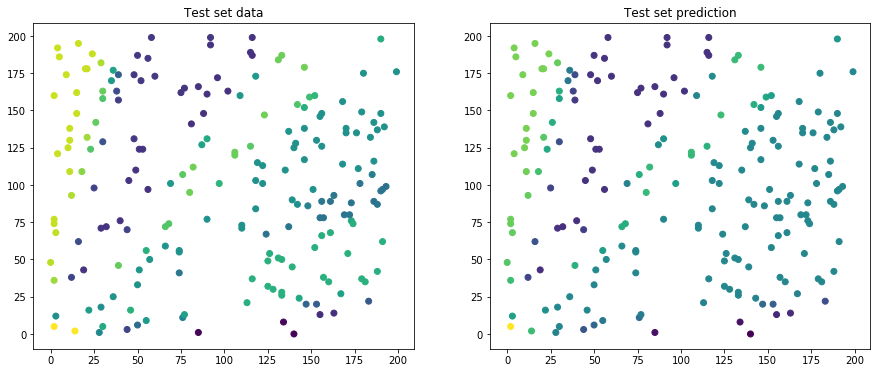

In [10]:
y_pred = network.predict(X_test)

f, ax = plt.subplots(1,2,figsize=(15,6))
ax= ax.ravel()
ax[0].scatter(X_test[:,0],X_test[:,1],c=y_test.ravel())
ax[0].set_title('Test set data');
ax[1].scatter(X_test[:,0],X_test[:,1],c=y_pred.ravel())
ax[1].set_title('Test set prediction');

### Dataset 2 (rolling_ex_data)

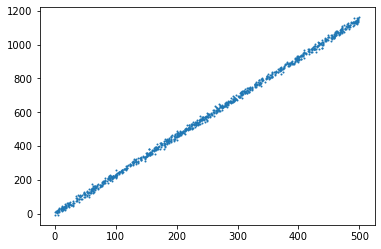

In [11]:
df = pd.read_csv('rolling_ex_data.csv')

X = np.array(df.iloc[:, 0]).reshape(-1, 1)
y = np.array(df.iloc[:, 1]).reshape(-1, 1)
plt.figure()
plt.scatter(X, y,s =1);

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

network2 = Network('mse',1e-6)
network2.add_layer(1,1,'identity')
network2.add_layer(1,1,'identity')


batch_size = 100
epochs = 50
e = network2.fit(X_train, y_train,batch_size,epochs)
y_pred = network2.predict(X_train)

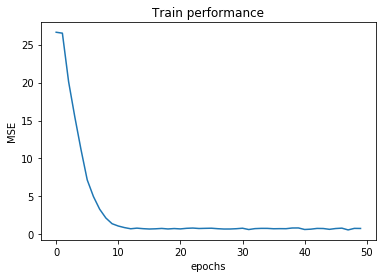

In [13]:
plt.figure()
plt.plot(e)
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Train performance');

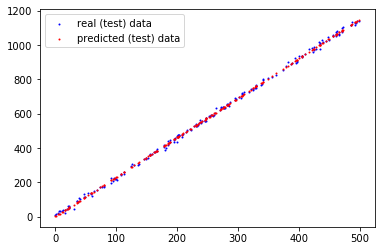

In [14]:
plt.scatter(X_test,y_test,c= 'b',s=1, label='real (test) data')
plt.scatter(X_test,network2.predict(X_test),c= 'r',s=1, label = 'predicted (test) data')
plt.legend();

## Compare loss functions

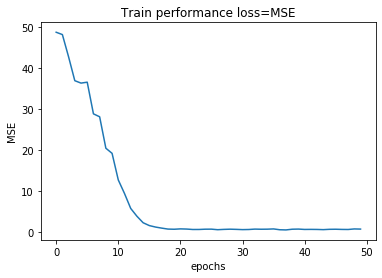

In [15]:
network2 = Network('mse',1e-6)
network2.add_layer(1,1,'identity')
network2.add_layer(1,1,'identity')


batch_size = 100
epochs = 50
e = network2.fit(X_train, y_train,batch_size,epochs)
plt.figure()
plt.plot(e)
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Train performance loss=MSE');

/home/sagiv/anaconda3/envs/main/lib/python3.6/site-packages/ipykernel_launcher.py:112: RuntimeWarning: invalid value encountered in log


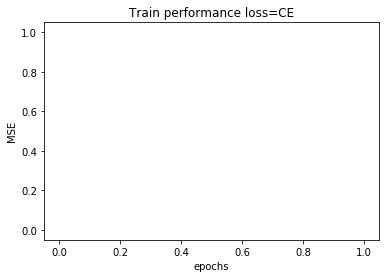

In [24]:
mynet = Network('cross_entropy',1e-5)
mynet.add_layer(1,1,'identity')
mynet.add_layer(1,1,'relu')


batch_size = 10
epochs = 10
e = mynet.fit(X_train, y_train,batch_size,epochs)
plt.figure()
plt.plot(e)
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Train performance loss=CE');

Cross entropy is not at all suitable to the second dataset as it is meant fo classification problems and here we are dealing with a regression problem. here, the y values are 1-1200, when inputing these in the cross entropy function we get invalid values so it cannot be run.

## Switching Sigmoid and Identity

### first dataset

In [25]:
df = pd.read_csv('one_hidden_data.csv', header=None)
X = np.array(df.iloc[:, 0:2])
y = np.array(df.iloc[:, 2]).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
network = Network('mse',1e-5)
network.add_layer(2,50,'identity')
network.add_layer(50,1,'identity')

batch_size = 30
epochs = 100000
e = network.fit(X_train, y_train,batch_size,epochs)
y_pred = network.predict(X_train)

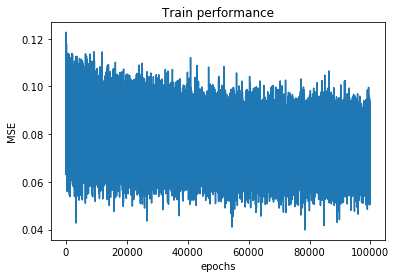

In [28]:
plt.plot(e[100:])
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Train performance');

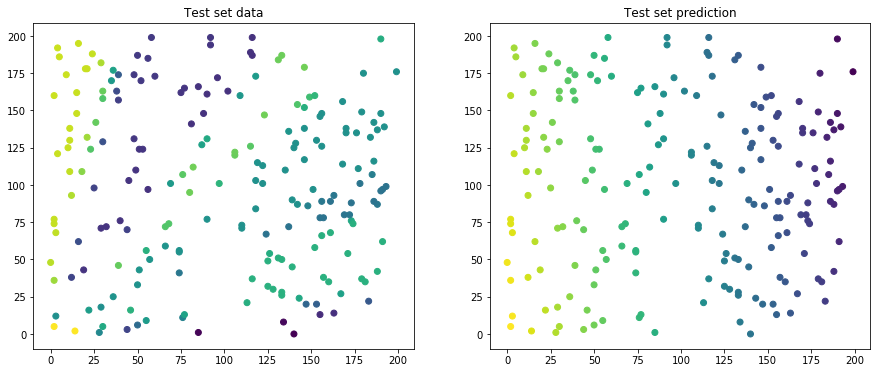

In [29]:
y_pred = network.predict(X_test)

f, ax = plt.subplots(1,2,figsize=(15,6))
ax= ax.ravel()
ax[0].scatter(X_test[:,0],X_test[:,1],c=y_test.ravel())
ax[0].set_title('Test set data');
ax[1].scatter(X_test[:,0],X_test[:,1],c=y_pred.ravel())
ax[1].set_title('Test set prediction');

When switching the inner layer activation function from sigmoid to identity, I've had to lower the learning rate by a magnitude of 4 just to get the net to converge, and even then got very bad results. this is due to the sigmoid ability to handle high backpropagation values, and the non-linearity it adds to the model.

### Second dataset

here the original hidden layer activation function wad linear due to the linear properties of the data. I'll switch it to sigmoid. Because the data is between 0-1200 and the sigmoid has a max of 1, I'll have to add some hidden layer perceptrons to reach 1200

In [30]:
df = pd.read_csv('rolling_ex_data.csv')

X = np.array(df.iloc[:, 0]).reshape(-1, 1)
y = np.array(df.iloc[:, 1]).reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

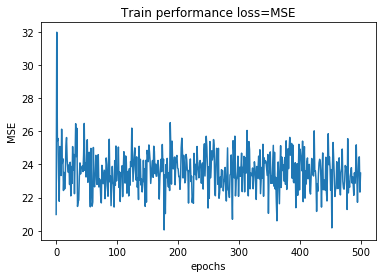

In [31]:
network2 = Network('mse',1e-4)
network2.add_layer(1,1200,'sigmoid')
network2.add_layer(1200,1,'identity')


batch_size = 100
epochs = 500
e = network2.fit(X_train, y_train,batch_size,epochs)
plt.figure()
plt.plot(e)
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Train performance loss=MSE');

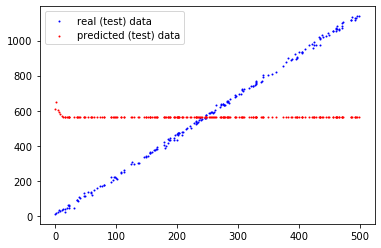

In [32]:
plt.scatter(X_test,y_test,c= 'b',s=1, label='real (test) data')
plt.scatter(X_test,network2.predict(X_test),c= 'r',s=1, label = 'predicted (test) data')
plt.legend();

Unfortunetly, I couldn't get the network to converge on any hyperparameters. My guess is that the sigmoid layer is confining the network to very low values and the identity layer cannot correct that.

As a side note: please try not to refer to datasets as #1 and #2 when they are not labeled as such and switched every week, I think the questions were written for different datasets and the originals were switched so many times that the questions have become irrelevant.